# Predict the size of the company you will join after graduation.

## Imports

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# use random forest to predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



In [23]:
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

## Read the Data

### licenses & certifications 

In [34]:
students_licenses = pd.read_csv('../data/preprocessed-data/csv/licenses.csv')

# drop na in Title column
students_licenses.dropna(subset=['Title'], inplace=True)

students_licenses.head()


,Title,Issuer,Date,User
0,Algorithms Analysis and Data Structures,Pluralsight,Issued Oct 2022,%D9%90%D9%90amiraelmergawy
1,Designing RESTful Web APIs,Pluralsight,Issued Sep 2022,%D9%90%D9%90amiraelmergawy
2,Programming Using C,Sololearn,Issued Aug 2022,%D9%90%D9%90amiraelmergawy
3,Advanced Express,LinkedIn,Issued Mar 2022,-ezz
4,Advanced Node.js,LinkedIn,Issued Mar 2022,-ezz


### education

In [25]:
students_education = pd.read_csv('../data/preprocessed-data/normalized csv/educations.csv')

students_education.dropna(subset=['university_name'], inplace=True)

# remove #iti from university_name
students_education = students_education[students_education['university_name'] != '#iti']

# get students whose university is in the top 10
top_10_universities = students_education['university_name'].value_counts().head(15).index

print(top_10_universities)

students_education = students_education[students_education['university_name'].isin(top_10_universities)]

print(len(students_education))
students_education.head()

Index(['cairo', 'ain shams', 'alexandria', 'mansoura', 'institute', 'guc',
       'zagazig', 'tanta', 'benha', 'helwan', 'modern academy', 'bue',
       'suez canal', 'minufiya', 'zewail city'],
      dtype='object')
737


,University,Degree,Date,User,university_name,faculty_name
1,ain shams university,"bachelor's degree, computer science",2016 - 2020,%D9%90%D9%90amiraelmergawy,ain shams,computer
7,ain shams university,"bachelor of engineering (b.eng.), computers an...",2013 - 2018,a-mohsen,ain shams,computer
10,cairo university,"bachelor's degree, communications and computer...",2014 - 2019,a-youssry,cairo,computer
11,cairo university,"bachelor of engineering - be, computer enginee...",2017 - 2022,aaarafat,cairo,computer
13,cairo university,"good, electronic and communication",2002 - 2007,aabdelsattaar,cairo,electronic


### companies

In [26]:
companies = pd.read_csv('../data/companies/companies.csv')

# remove na companySize
companies.dropna(subset=['companySize'], inplace=True)

# select only companySize column
companies = companies[['companySize','name','query']]
print(companies['companySize'].value_counts())
companies.head()

11-50 employees           336
51-200 employees          220
2-10 employees            123
201-500 employees         114
1,001-5,000 employees      86
10,001+ employees          86
501-1,000 employees        56
5,001-10,000 employees     35
0-1 employees               7
Name: companySize, dtype: int64


,companySize,name,query
0,51-200 employees,National Telecommunication Institute (NTI),https://www.linkedin.com/company/15805726/
2,11-50 employees,(ISCC) International Staffing & Consulting Co.,https://www.linkedin.com/company/2205041/
3,11-50 employees,sonono,https://www.linkedin.com/company/30101254/
4,"1,001-5,000 employees",Etisalat Egypt,https://www.linkedin.com/company/777868/
5,11-50 employees,"The Translation Gate, LLC",https://www.linkedin.com/company/2229028/


### experiences

In [27]:
students_experiences = pd.read_csv('../data/preprocessed-data/normalized csv/experiences.csv', converters={'From': pd.to_datetime})
students_experiences[students_experiences['User'] == '-ezz']

,User,CompanyUrl,Company,Title,EmploymentType,From,To,Duration,Location,title_tag
4,-ezz,https://www.linkedin.com/company/30101254/,sonono,software engineer,Full-time,2022-01-01,Present,16.0,"Basel, Switzerland",software
5,-ezz,https://www.linkedin.com/company/294614/,Information Technology Institute (ITI),internship trainee,Full-time,2021-10-01,Jan 2022,4.0,Egypt,internship
6,-ezz,UNKNOWN,CEL - Consulting Engineering Bureau,senior geotechnical engineer,Full-time,2019-09-01,Aug 2020,12.0,Egypt,NaN


In [28]:
# sort by From date
students_experiences.sort_values(by='From', inplace=True)

# keep only the first experience for each student
students_experiences.drop_duplicates(subset=['User'], keep='first', inplace=True)

print(len(students_experiences))
students_experiences.head()

835


,User,CompanyUrl,Company,Title,EmploymentType,From,To,Duration,Location,title_tag
1451,ibrahim-sobh-phd-8681757,https://www.linkedin.com/company/6659/,Orascom Telecom,intern,NaN,1996-06-01,Aug 1996,3.0,NaN,internship
3215,tarekdawoud,UNKNOWN,ICCC,"software developer, lead software developer",NaN,1998-01-01,2000,24.0,NaN,Lead
1768,mahmoud-mohasseb-9b8b514,UNKNOWN,POET egypt,application programmer,NaN,2003-12-01,Dec 2004,13.0,"EGYPT, Alexandria",NaN
2482,mona-shafiq-pmp-itil-68b435b3,UNKNOWN,Bright Worx,web development trainee,NaN,2006-07-01,Sep 2006,3.0,Maadi,full-stack
704,amr-el-agamy-45a72a2,https://www.linkedin.com/company/2697/,Mentor Graphics,software development engineer,NaN,2006-08-01,Jul 2012,72.0,NaN,software


In [29]:
# join experiences with companies
students_experiences = students_experiences.merge(companies, left_on='Company', right_on='name', how='left')

# join experiences with education
students_experiences = students_experiences.merge(students_education, left_on='User', right_on='User', how='left')

students_experiences.head()

,User,CompanyUrl,Company,Title,EmploymentType,From,To,Duration,Location,title_tag,companySize,name,query,University,Degree,Date,university_name,faculty_name
0,ibrahim-sobh-phd-8681757,https://www.linkedin.com/company/6659/,Orascom Telecom,intern,NaN,1996-06-01,Aug 1996,3.0,NaN,internship,"10,001+ employees",Orascom Telecom,https://www.linkedin.com/company/6659/,cairo university,"phd -, machine learning, deep learning, reinfo...",2011 - 2017,cairo,NaN
1,ibrahim-sobh-phd-8681757,https://www.linkedin.com/company/6659/,Orascom Telecom,intern,NaN,1996-06-01,Aug 1996,3.0,NaN,internship,"10,001+ employees",Orascom Telecom,https://www.linkedin.com/company/6659/,cairo university,"m.sc, machine learning, automatic document sum...",2005 - 2009,cairo,NaN
2,ibrahim-sobh-phd-8681757,https://www.linkedin.com/company/6659/,Orascom Telecom,intern,NaN,1996-06-01,Aug 1996,3.0,NaN,internship,"10,001+ employees",Orascom Telecom,https://www.linkedin.com/company/6659/,cairo university,"b.sc, computer engineering",1992 - 1997,cairo,computer
3,tarekdawoud,UNKNOWN,ICCC,"software developer, lead software developer",NaN,1998-01-01,2000,24.0,NaN,Lead,NaN,NaN,NaN,cairo university,"bachelor of science (b.sc.), computer engineering",1992 - 1997,cairo,computer
4,mahmoud-mohasseb-9b8b514,UNKNOWN,POET egypt,application programmer,NaN,2003-12-01,Dec 2004,13.0,"EGYPT, Alexandria",NaN,NaN,NaN,NaN,alexandria university,"b.sc., computer science",1997 - 2002,alexandria,computer


---

##  Relation between the size of the company and the university

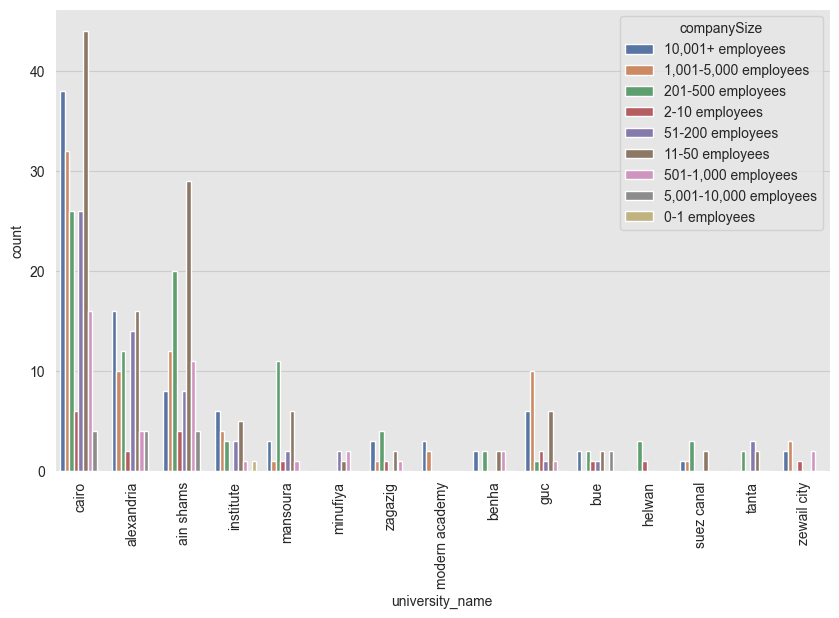

Text(0.5, 1.0, 'Relation Between Gender and Body Level')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

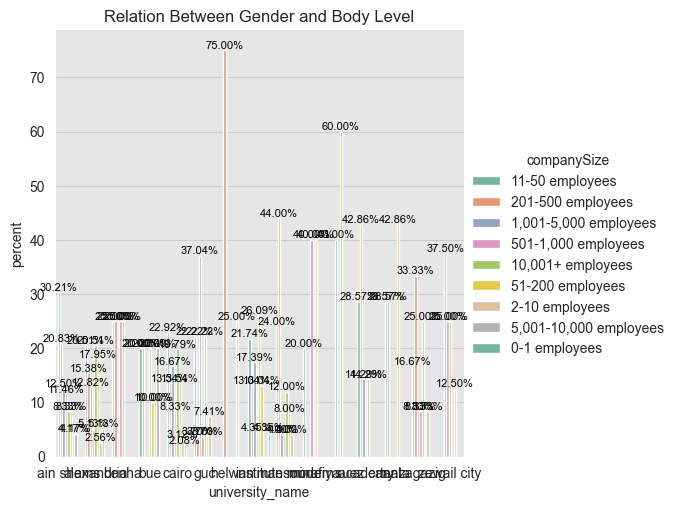

In [44]:
# plot university_name against companySize
plt.figure(figsize=(10, 6))
sns.countplot(x='university_name', hue='companySize', data=students_experiences)
plt.xticks(rotation=90)
plt.show()


## Model 

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df = students_experiences[['university_name', 'companySize']]

# drop na
df = df.dropna()

# encode university_name
df = pd.get_dummies(df, columns=['university_name'])

# encode companySize
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['companySize'] = le.fit_transform(df['companySize'])

X = df.drop(columns=['companySize'])
y = df['companySize']

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)



### RandomForestClassifier

In [56]:
# create a ml model to predict companySize based on university_name
# use random forest to predict
from sklearn.ensemble import RandomForestClassifier

# create random forest regressor
rf = RandomForestClassifier(n_estimators=10, max_depth=3)

# fit the model
rf.fit(X_train, y_train)

# predict
y_pred = rf.predict(X_test)

# evaluate
accuracy_score(y_test, y_pred)

0.21568627450980393